In [133]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib as plt

In [134]:
## To acquire stock list in thailand ###
ex = pd.read_excel('update_data/stock_info_th.xlsx', sheet_name='listedCompanies_th_TH',skiprows=1)
df = pd.DataFrame(ex['หลักทรัพย์'].astype('str') + '.bk')
df['market'] = ex['ตลาด']
df = df.rename(columns={'หลักทรัพย์' : 'ticker'})
df = df.reset_index(drop=True)

# 1st pulling date for this data #
df['date_pulling'] = date.today()
df

,ticker,market,date_pulling
0,24CS.bk,mai,2024-09-19
1,2S.bk,SET,2024-09-19
2,3BBIF.bk,SET,2024-09-19
3,3K-BAT.bk,SET,2024-09-19
4,A.bk,SET,2024-09-19
...,...,...,...
916,YONG.bk,mai,2024-09-19
917,YUASA.bk,mai,2024-09-19
918,ZAA.bk,SET,2024-09-19
919,ZEN.bk,SET,2024-09-19


In [135]:
### Create a ratio called Operating Income/basic share ######

# 2nd acquiring information from .info #
def yfinance_normalised_OI_index(ticker,property):
    ### Get data from .financials and .quaterly_financials ####
    try:
        data_financials = yf.Ticker(ticker).financials.loc[yf.Ticker(ticker).financials.index == property].dropna(axis = 1, how = 'all')
        data_financials = data_financials.T
        # print(data_financials)
        
        data_quaterly_financials = yf.Ticker(ticker).quarterly_financials.loc[yf.Ticker(ticker).quarterly_financials.index == property].dropna(axis = 1, how = 'all')
        list_col = data_quaterly_financials.columns
        data_quaterly_financials = data_quaterly_financials.reset_index()
        data_quaterly_financials['ttm'] = 0
        if len(list_col) >=4 :
            ttm_period = 4
        else : ttm_period = len(list_col)
        for i in range(ttm_period): 
            data_quaterly_financials['ttm'] = data_quaterly_financials['ttm'] + data_quaterly_financials[list_col[i]]
        data_quaterly_financials = data_quaterly_financials.set_index('index')
        data_quaterly_financials = data_quaterly_financials.T
        # print(data_quaterly_financials.loc[data_quaterly_financials.index == 'ttm'])
              
        data = pd.concat([data_quaterly_financials.loc[data_quaterly_financials.index == 'ttm'],data_financials])

        minval = data[property].astype('float64').min()
        maxval = data[property].astype('float64').max()
        numofyear = len(data[property])
        data[property] = ( data[property] - minval ) / (maxval - minval)
        
        #### Calculate beta ###
        data.reset_index(inplace=True)
        data = data.rename(columns = {'index':'time'})
        data.reset_index(inplace=True)
        data = data.sort_values('index',ascending=False)
        data = data.drop(columns = 'index')
        data.reset_index(inplace=True,drop = True)
        beta, alpha = np.polyfit(np.array(data[property]).astype('float64'), np.array(data.index).astype('float64'),1)
        # data[property].plot()
        return beta , numofyear
    except: 
        return None

    

data , num = yfinance_normalised_OI_index('MEGA.BK','Operating Income')
print(data, num)

3.5625518936802996 5


In [136]:
#### Calculate ROIC #####
def yfinance_average_ROI(ticker,property) :
    try:
        investedcapital = yf.Ticker(ticker).balance_sheet.dropna(axis = 1, how = 'all')
        investedcapital = investedcapital.T
        investedcapital = investedcapital['Invested Capital']

        earninngs = yf.Ticker(ticker).financials.dropna(axis = 1, how = 'all')
        earninngs = earninngs.T
        earninngs = earninngs[property]

        data = pd.DataFrame()
        data['Invested Capital'] = investedcapital
        data[property] = earninngs
        data = data.dropna()
        data['avg_MF_ROC'] = data[property]/data['Invested Capital']
        avg_MF_ROC = data['avg_MF_ROC'].mean()
        return avg_MF_ROC
    except:
        return None


print(yfinance_average_ROI('MEGA.BK','Operating Income'))

0.27391790032544266


4.000000000000001 -1.1102230246251565e-16


<Axes: >

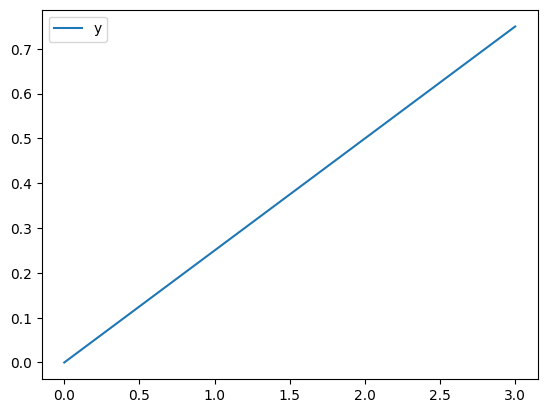

In [137]:
y = [0,0.25,0.5,0.75]
data = pd.DataFrame()
data['y'] = y
beta, alpha = np.polyfit(data['y'], data.index, 1)
print(beta, alpha)

data.plot()